# Numerical differentiation of noisy data: Ground truth results

This notebook builds based on `1_basic_tutorial.ipynb` by calling optimization routines to find optimal parameters for each method.

### Notations:
  * dt: (float) time step (note: we concentrated on differentiating timeseries data, however these functions work for a 1-dimensional spatial derivative as well)
  * x: (np.array with length N) the time series you want to differentiate
  * x_hat: (np.array with length N) the smoothed estimate of x
  * x_truth: (np.array with length N) the true value of x (which is known when the data is simulated, and used for plotting purposes only)
  * dxdt_hat: (np.array with length N) the estimate of the derivative of x
  * dxdt_truth: (np.array with length N) the true value of dxdt (which is known when the data is simulated, and used for plotting purposes only)

In [1]:
import os
import sys
import time
import numpy as np

# local import
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pynumdiff
import pynumdiff.optimize

simulate = pynumdiff.utils.simulate
evaluate = pynumdiff.utils.evaluate

%matplotlib inline

# 0. Simulate some data

pynumdiff comes with 6 different toy problems (choose the one that most resembles your data to see how the methods compare):
* lorenz_x: (nonlinear) x component of a lorenz attractor
* sine: (linear) sum of two sines
* pop_dyn: (nonlinear) bounded exponential growth
* triangle: (nonlinear) sharp-edged triangle wave with increasing frequency
* pi_control: (linear / nonlinear) linear proportional integral controller with nonlinear control inputs

In [2]:
# simulation parameters

# noise is generated using np.random, e.g. np.random.normal, np.random.uniform, np.random.poisson
# noise_type and noise_parameters should be compatible with np.random functions 
noise_type = 'normal'
noise_parameters = [0, 0.01]

# time step and time series length
dt = 0.1  # sampling time step
simdt = 0.01  # simulation timestep
timeseries_length =  50  # sec
problem = 'pi_control'

In [3]:
# simulate data

x, x_truth, dxdt_truth, extras = r = pynumdiff.utils.simulate.__dict__[problem](timeseries_length, 
                                                                                noise_parameters=noise_parameters, 
                                                                                dt=dt, 
                                                                                simdt=0.01)

In [4]:
# For our toy problems we can optimize the parameters in one of two options:
# 1. Use the known dxdt to find the best parameters 
# 2. Actual dxdt is unknown

# In the real world, option (1) is not possible. 

# This notebook allows you to run the optimization with either option:
# cheat=True selects option (1)
# cheat=False selects option (2)

cheat = True

if cheat:
    dxdt_truth_vals = dxdt_truth
else:
    dxdt_truth_vals = None

The optimization approach described here solves a loss function that balances the faithfulness and smoothness of the derivative estimate, and relies on a single hyperparameter, $\gamma$, or `tvgamma` in the code. See the paper for more detail, but a brief overview is given here.

The loss function to find the optimal parameters is as follows,

$$L = \mbox{RMSE} \bigg( \mbox{trapz}(\mathbf{\hat{\dot{x}}}(\Phi)) + \mu, \mathbf{y} \bigg) + \gamma \bigg({TV}\big(\mathbf{\hat{\dot{x}}}(\Phi)\big)\bigg),$$
where $\mathbf{y}$ are the noisy measurements, $\mathbf{\hat{\dot{x}}}$ is the estimate of the derivative, $\mbox{trapz}(\cdot)$ is the discrete-time trapezoidal numerical integral, $\mu$ resolves the unknown integration constant, \\(\gamma\\) is a hyper-parameter, and $TV$ is the total variation,

$$TV(\mathbf{\hat{\dot{x}}}) = \frac{1}{m}\left\lVert\mathbf{\hat{\dot{x}}}_{0:m-1}-\mathbf{\hat{\dot{x}}}_{1:m}\right\rVert_{1}.$$

To use the code to  solve the loss function and find your optimal parameters is quite simple.

First, find tvgamma using the following heuristic: 

In [5]:
cutoff_frequency = 0.1 # high frequency of signal in the data
log_gamma = -1.6*np.log(cutoff_frequency) - 0.71*np.log(dt) - 5.1
tvgamma = np.exp(log_gamma)

Then, use the following syntax, as detailed in the notebook.

    params, val = pynumdiff.optimize.sub_module.method(x, dt, params=None, 
                                                   tvgamma=tvgamma, # hyperparameter
                                                   dxdt_truth=None, # no ground truth data
                                                   options={})
    print('Optimal parameters: ', params)
    x_hat, dxdt_hat = pynumdiff.sub_module.method(x, dt, params, options={'smooth': True})

In [6]:
if cheat:  # so the code doesn't break
    tvgamma = 0  # since we are optimizing on the actual values, no need to regularize
    
print('tvgamma = ', tvgamma)

tvgamma =  0


## 1. Finite Difference

### 1.1 Finite Difference: First Order

RMS error in velocity:  2.9976957350630586


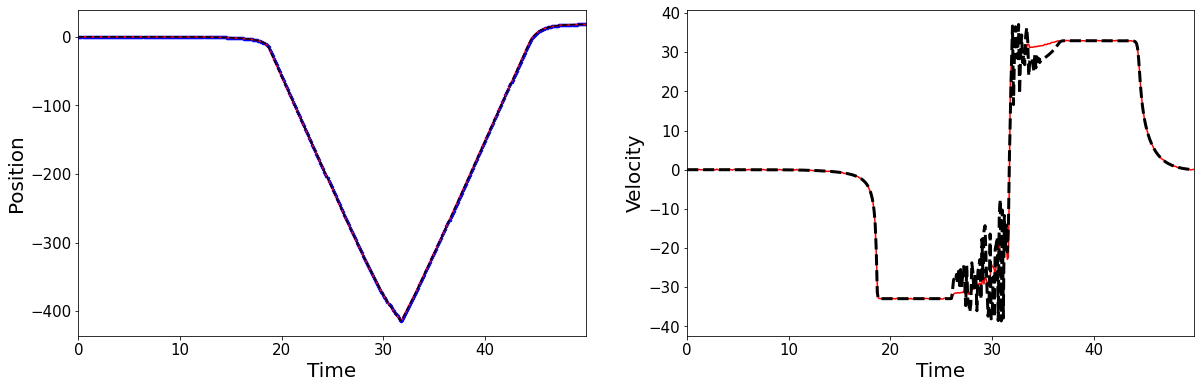

In [7]:
x_hat, dxdt_hat = pynumdiff.finite_difference.first_order(x, dt)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 1.2 Finite Difference: Second Order

RMS error in velocity:  2.9976957350630586


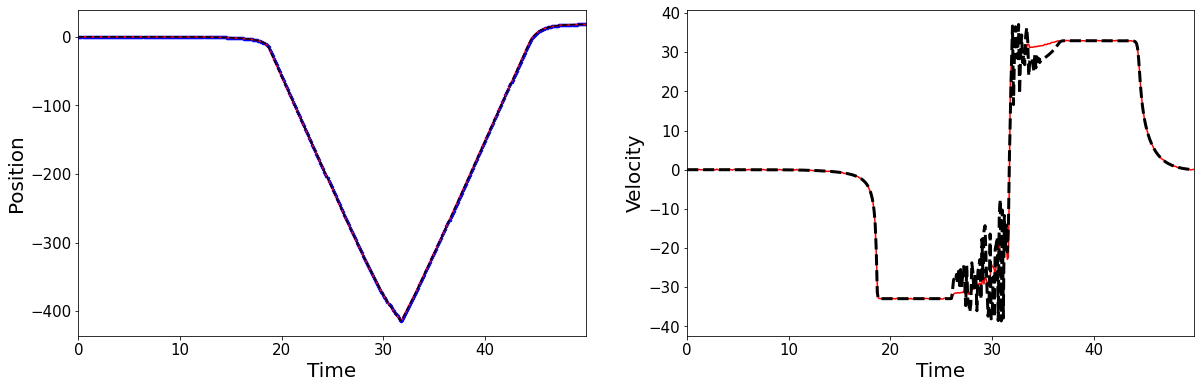

In [8]:
x_hat, dxdt_hat = pynumdiff.finite_difference.first_order(x, dt)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 1.3 Finite Difference: Iterated First Order

Optimal parameters:  [1]
RMS error in velocity:  2.946149793079535


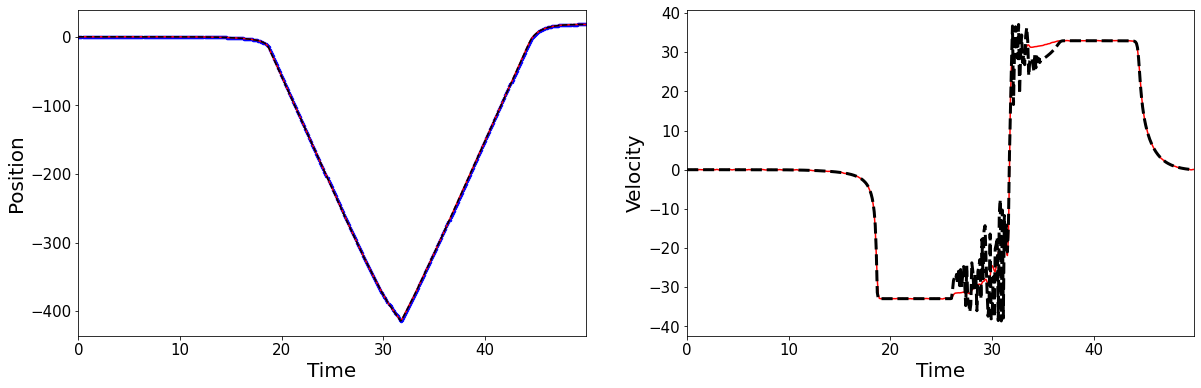

In [9]:
params, val = pynumdiff.optimize.finite_difference.first_order(x, dt, params=None,
                                                               options={'iterate': True},
                                                               tvgamma=tvgamma,
                                                               dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.finite_difference.first_order(x, dt, params, options={'iterate': True})
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 2. Smooth Finite Difference

### 2.1 Smooth Finite Difference: Median smoothing

Optimal parameters:  [5, 5]
RMS error in velocity:  2.9547277445783133


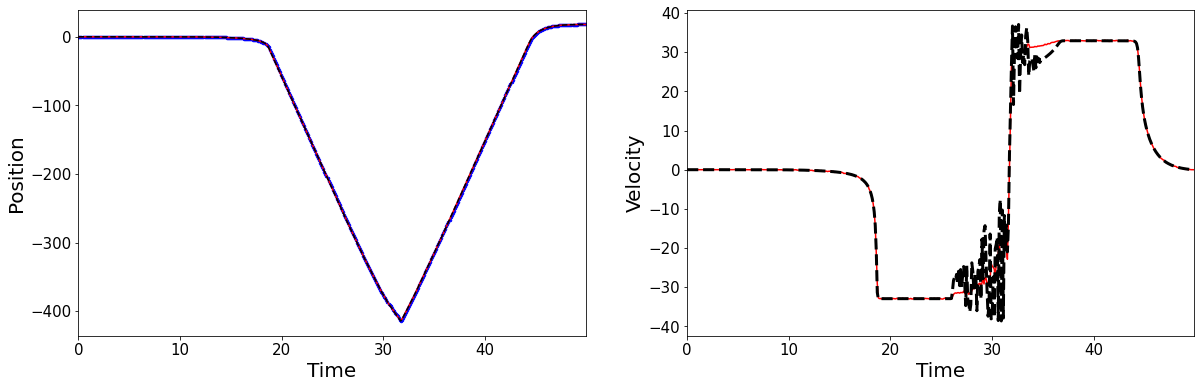

In [10]:
params, val = pynumdiff.optimize.smooth_finite_difference.mediandiff(x, dt, params=None, 
                                                                     options={'iterate': True},
                                                                     tvgamma=tvgamma,
                                                                     dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.mediandiff(x, dt, params, options={'iterate': True})
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.2 Smooth Finite Difference: Mean smoothing

Optimal parameters:  [3, 1]
RMS error in velocity:  2.9395038045835884


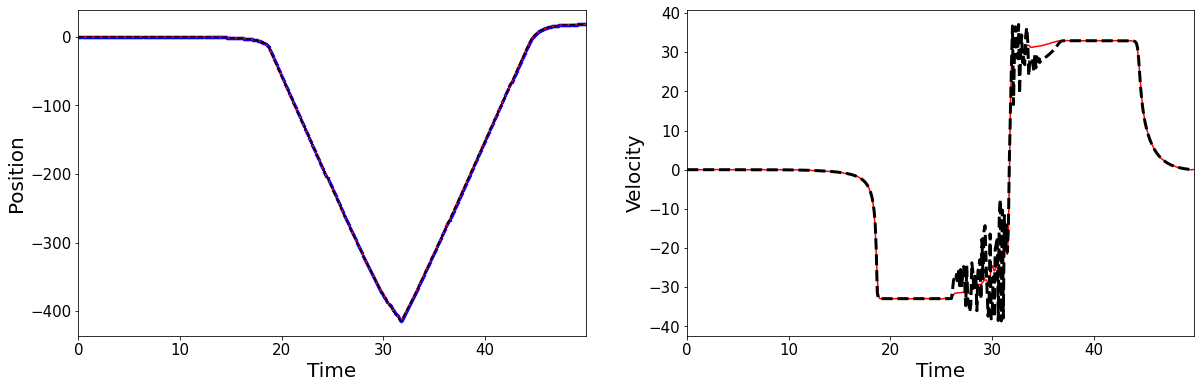

In [11]:
params, val = pynumdiff.optimize.smooth_finite_difference.meandiff(x, dt, params=None, 
                                                                   options={'iterate': True},
                                                                   tvgamma=tvgamma,
                                                                   dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.meandiff(x, dt, params, options={'iterate': True})
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.3 Smooth Finite Difference: Gaussian smoothing

Optimal parameters:  [4, 1]
RMS error in velocity:  2.946096482028807


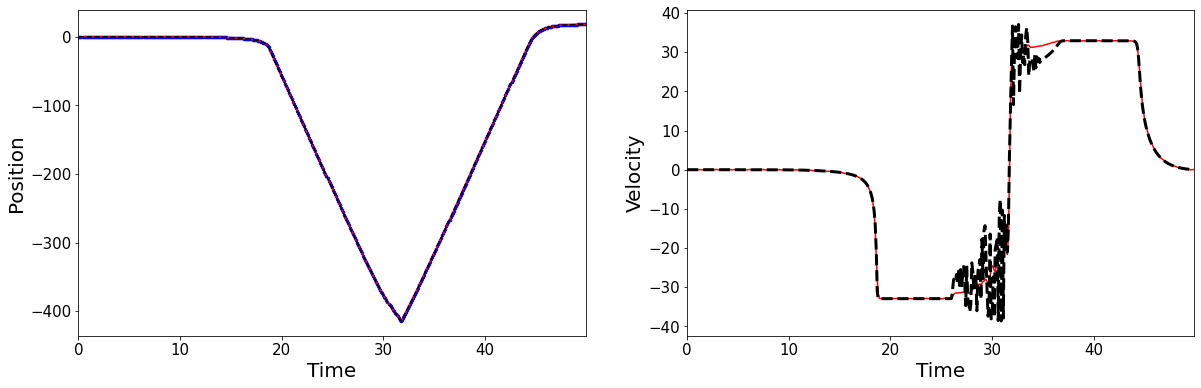

In [12]:
params, val = pynumdiff.optimize.smooth_finite_difference.gaussiandiff(x, dt, params=None, 
                                                                       options={'iterate': True},
                                                                       tvgamma=tvgamma,
                                                                       dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.gaussiandiff(x, dt, params, options={'iterate': True})
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.4 Smooth Finite Difference: Friedrichs smoothing

Optimal parameters:  [5, 1]
RMS error in velocity:  2.9419283982793


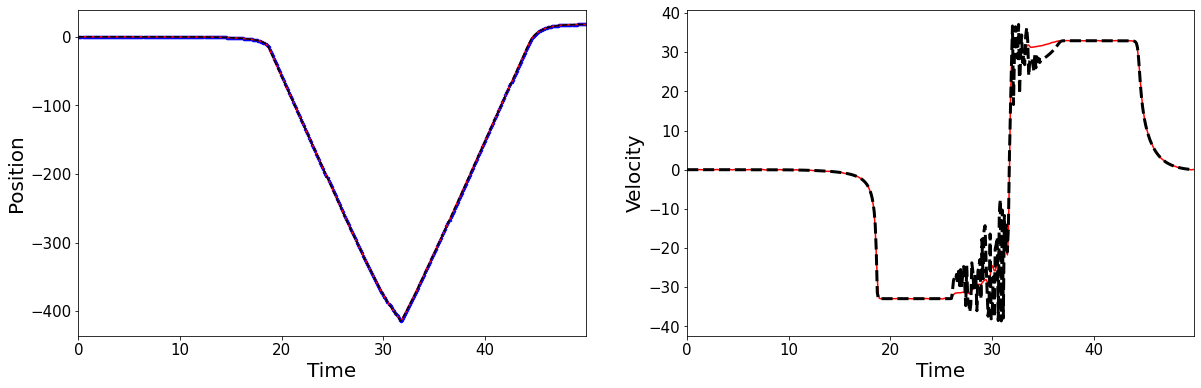

In [13]:
params, val = pynumdiff.optimize.smooth_finite_difference.friedrichsdiff(x, dt, params=None, 
                                                                         options={'iterate': True},
                                                                         tvgamma=tvgamma,
                                                                         dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.friedrichsdiff(x, dt, params, options={'iterate': True})
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.5 Smooth Finite Difference: Butterworth smoothing

Optimal parameters:  [7, 0.49300078113092505, 10]
RMS error in velocity:  2.9378436732107245


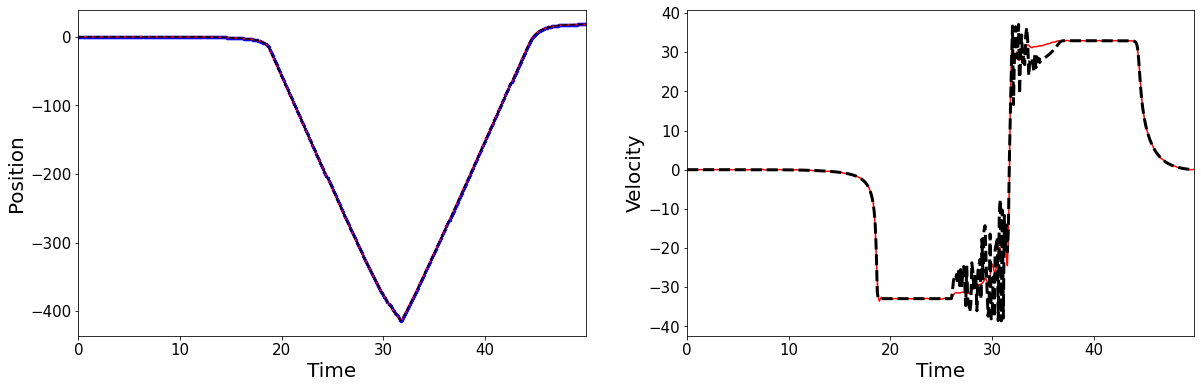

In [14]:
params, val = pynumdiff.optimize.smooth_finite_difference.butterdiff(x, dt, params=None, 
                                                                     options={'iterate': True},
                                                                     tvgamma=tvgamma,
                                                                     dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.butterdiff(x, dt, params, options={'iterate': True})
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.6 Smooth Finite Difference: Spline smoothing

Optimal parameters:  [3, 0.6704990352226817, 3]
RMS error in velocity:  2.9547164306499334


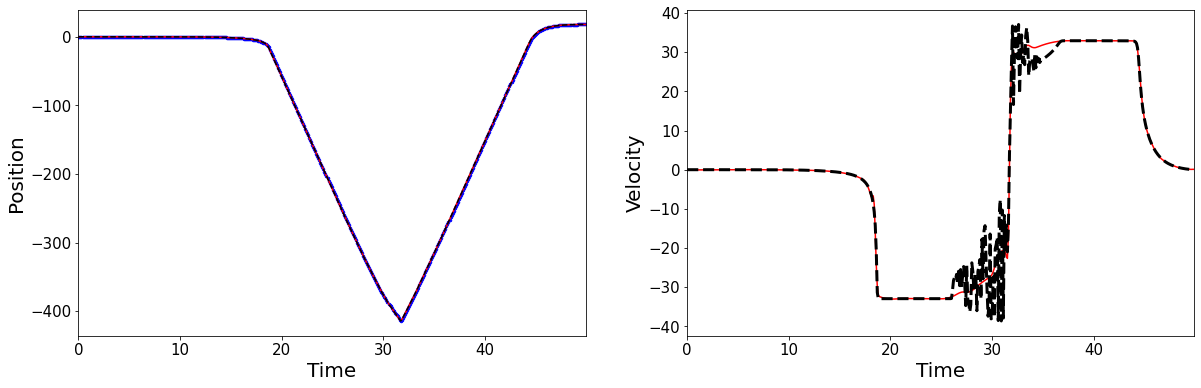

In [15]:
params, val = pynumdiff.optimize.smooth_finite_difference.splinediff(x, dt, params=None, 
                                                                     options={'iterate': True},
                                                                     tvgamma=tvgamma,
                                                                     dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.splinediff(x, dt, params, options={'iterate': True})
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 3. Total Variation Regularization

### 3.1 Iterative Total Variation Regularization (regularized velocity)

Optimal parameters:  [1, 0.1357812500000001]
RMS error in velocity:  3.3635127557905498


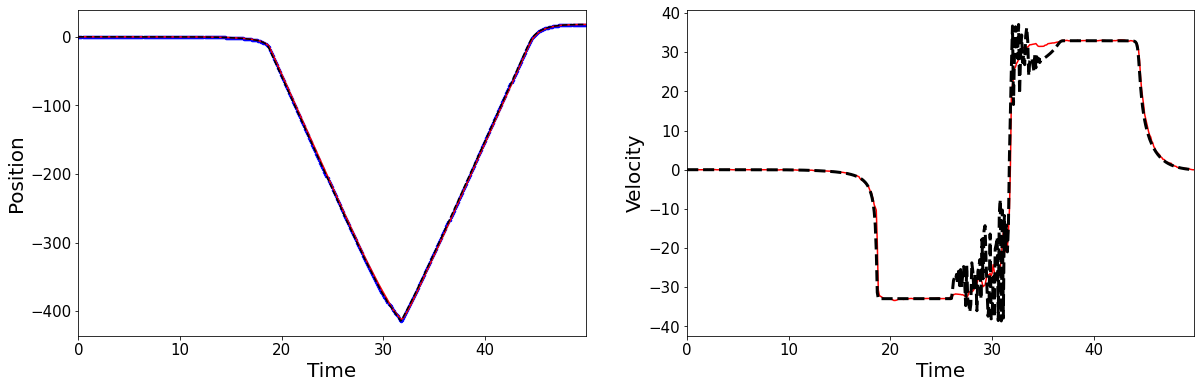

In [16]:
params, val = pynumdiff.optimize.total_variation_regularization.iterative_velocity(x, dt, params=None, 
                                                                                   tvgamma=tvgamma,
                                                                                   dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.total_variation_regularization.iterative_velocity(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.2 Convex Total Variation Regularization: regularize velocity

Optimal parameters:  [0.003750000000000187]
RMS error in velocity:  2.9799775120003216


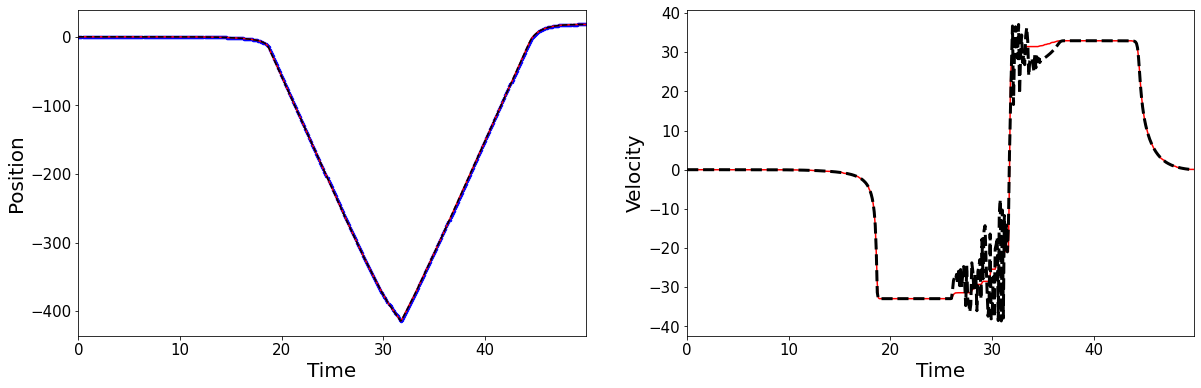

In [17]:
params, val = pynumdiff.optimize.total_variation_regularization.velocity(x, dt, params=None, 
                                                                         tvgamma=tvgamma,
                                                                         dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.total_variation_regularization.velocity(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.3 Convex Total Variation Regularization: regularize acceleration

Optimal parameters:  [0.010234375000000176]
RMS error in velocity:  2.952349656279022


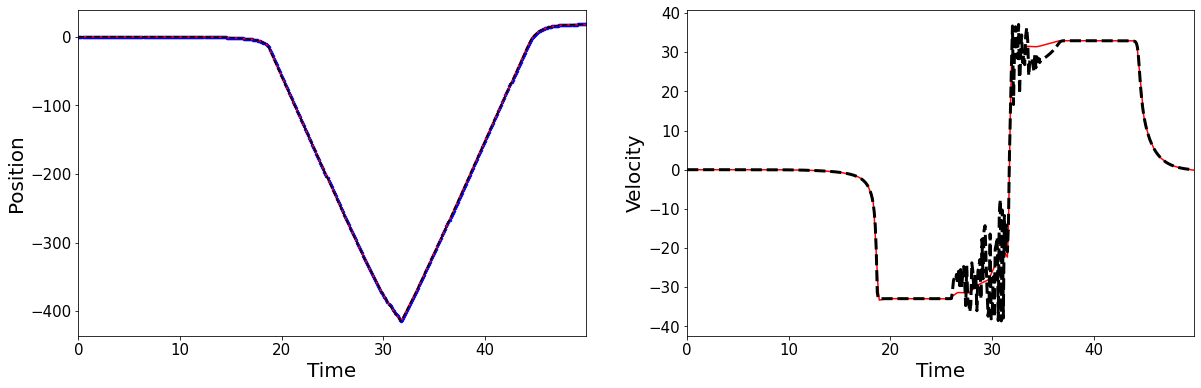

In [18]:
params, val = pynumdiff.optimize.total_variation_regularization.acceleration(x, dt, params=None,
                                                                             tvgamma=tvgamma,
                                                                             dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.total_variation_regularization.acceleration(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.4 Convex Total Variation Regularization: regularize jerk

Optimal parameters:  [0.012812500000000171]
RMS error in velocity:  2.977716954234661


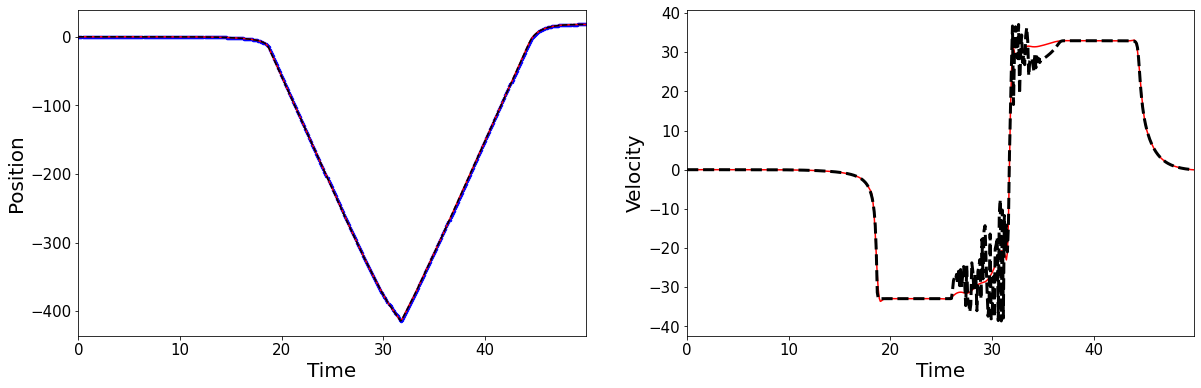

In [19]:
params, val = pynumdiff.optimize.total_variation_regularization.jerk(x, dt, params=None, 
                                                                     tvgamma=tvgamma,
                                                                     dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.total_variation_regularization.jerk(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.5 Convex Total Variation Regularization: regularize acceleration with gaussian smoothing

Optimal parameters:  [0, 5]
RMS error in velocity:  2.9478455304155045


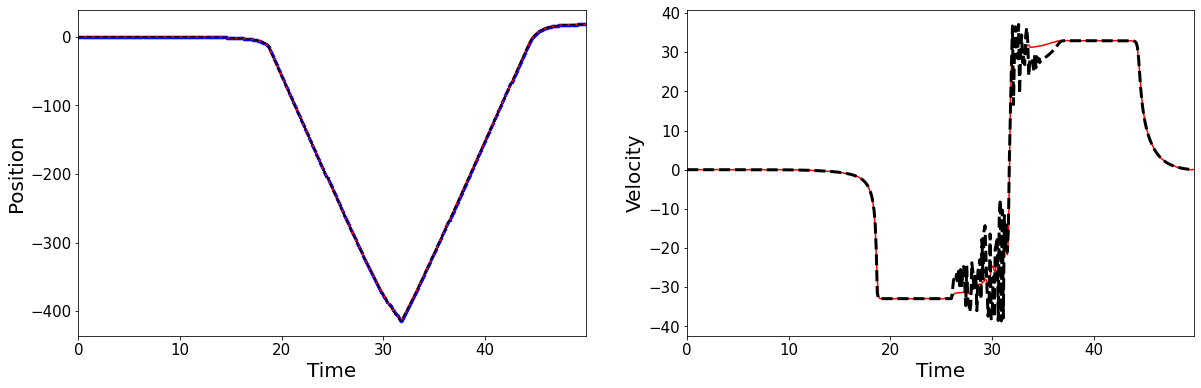

In [20]:
params, val = pynumdiff.optimize.total_variation_regularization.smooth_acceleration(x, dt, params=None, 
                                                                                    tvgamma=tvgamma,
                                                                                    dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.total_variation_regularization.smooth_acceleration(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 4. Linear Models

### 4.1 Linear Models: Spectral derivative

Optimal parameters:  [0.08875000000000013]
RMS error in velocity:  3.034518919146185


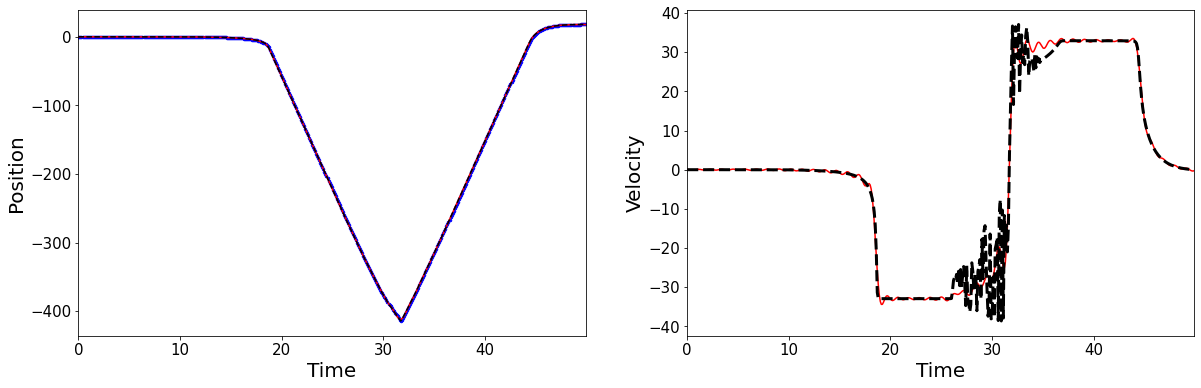

In [21]:
params, val = pynumdiff.optimize.linear_model.spectraldiff(x, dt, params=None, 
                                                           tvgamma=tvgamma,
                                                           dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.linear_model.spectraldiff(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.2 Linear Models: Sliding polynomial fit

Optimal parameters:  [4, 10]
RMS error in velocity:  2.9915496071856027


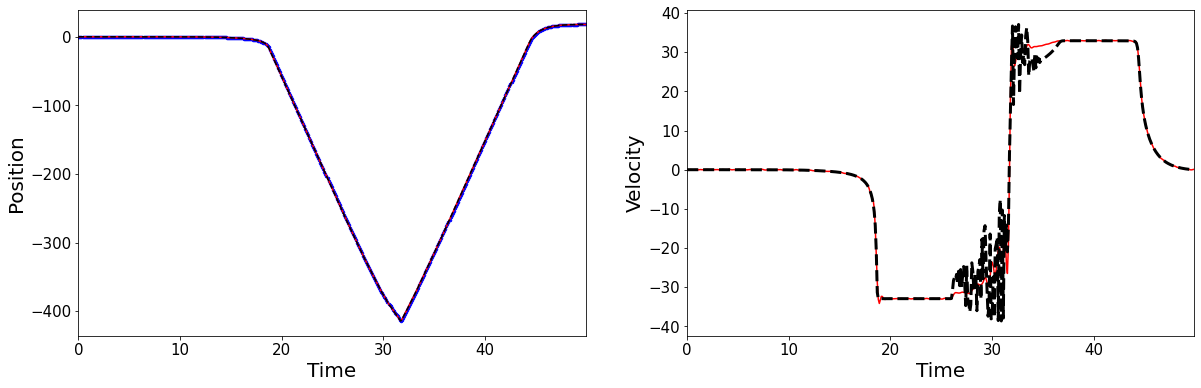

In [22]:
params, val = pynumdiff.optimize.linear_model.polydiff(x, dt, params=None, 
                                                       tvgamma=tvgamma,
                                                       dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.linear_model.polydiff(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.3 Linear Models: Savitzky-Golay filter

Optimal parameters:  [2, 3, 3]
RMS error in velocity:  2.9904977213750135


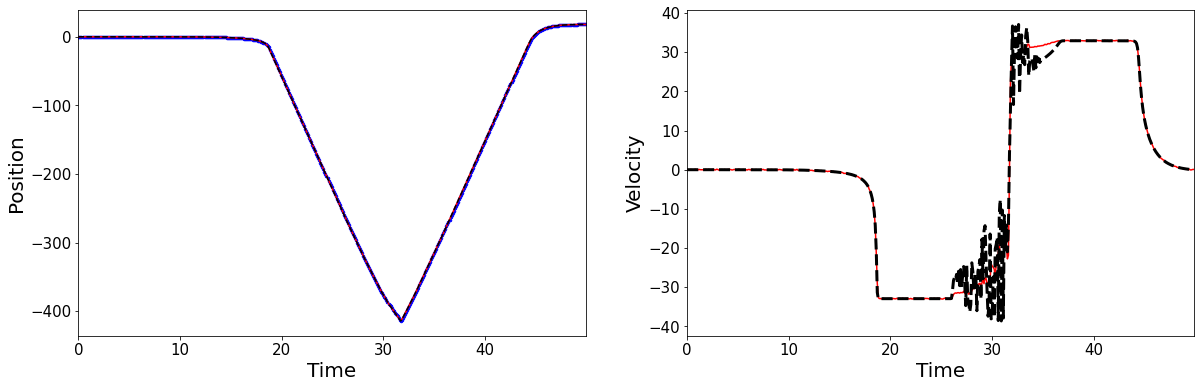

In [23]:
params, val = pynumdiff.optimize.linear_model.savgoldiff(x, dt, params=None, 
                                                         tvgamma=tvgamma,
                                                         dxdt_truth=dxdt_truth_vals,
                                                         options={'smooth': True})
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.linear_model.savgoldiff(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.4 Linear Models: Sliding chebychev polynomial fit

Optimal parameters:  [8, 27]
RMS error in velocity:  2.938607297197014


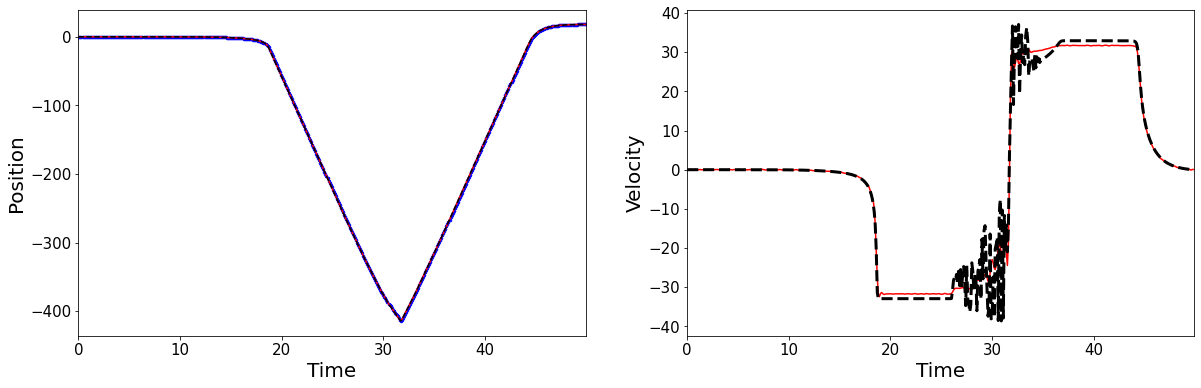

In [24]:
params, val = pynumdiff.optimize.linear_model.chebydiff(x, dt, params=None, 
                                                        tvgamma=tvgamma,
                                                        dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.linear_model.chebydiff(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.5 Linear Models: Sliding linear time invariant system fit

In [25]:
if 0: # this one is too slow!
    params, val = pynumdiff.optimize.linear_model.lineardiff(x, dt, params=None, 
                                                             tvgamma=tvgamma,
                                                             dxdt_truth=dxdt_truth_vals)
    print('Optimal parameters: ', params)
    x_hat, dxdt_hat = pynumdiff.linear_model.lineardiff(x, dt, params)
    evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## Kalman smoothing

### 5.1 Kalman smoothing: constant velocity (forward-backward)

Optimal parameters:  [0.10100097656250001, 10.302490234375]
RMS error in velocity:  2.96789004522868


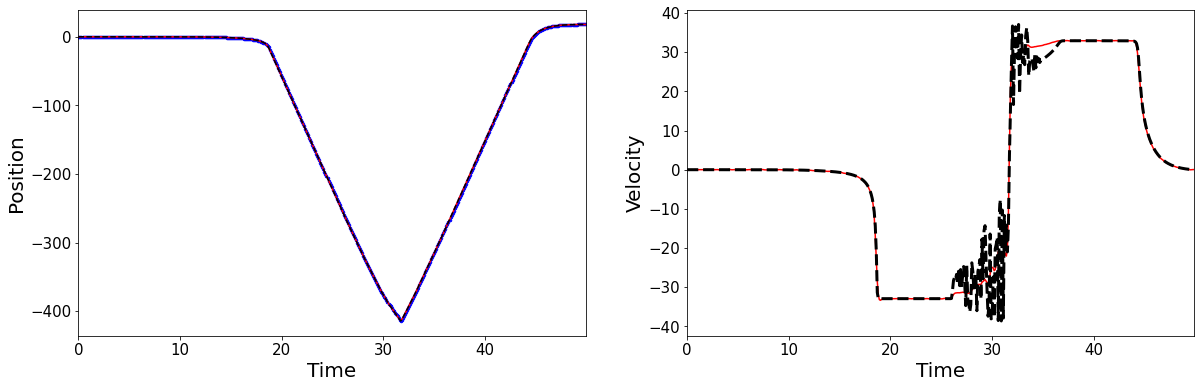

In [26]:
params, val = pynumdiff.optimize.kalman_smooth.constant_velocity(x, dt, params=None, 
                                                                 tvgamma=tvgamma,
                                                                 dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.kalman_smooth.constant_velocity(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 5.2 Kalman smoothing: constant acceleration (forward-backward)

Optimal parameters:  [10079.1015625, 106425781.25]
RMS error in velocity:  3.011505398110939


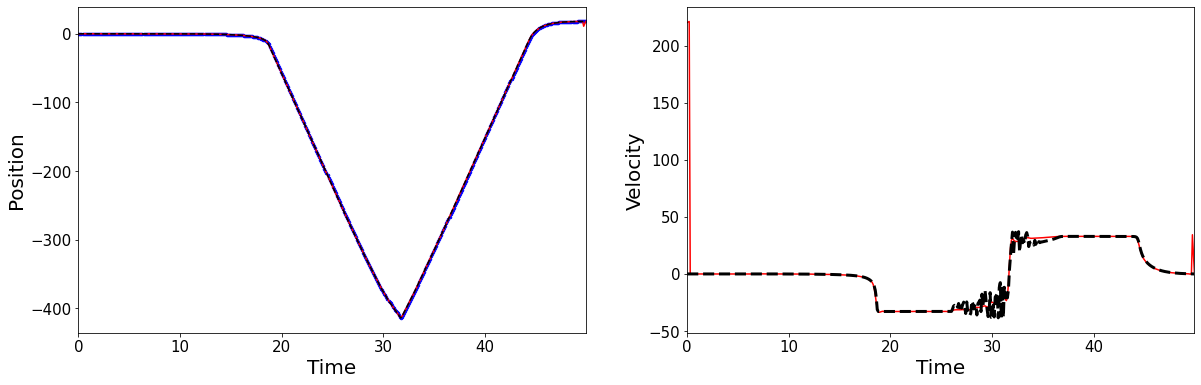

In [27]:
params, val = pynumdiff.optimize.kalman_smooth.constant_acceleration(x, dt, params=None,
                                                                     tvgamma=tvgamma,
                                                                     dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.kalman_smooth.constant_acceleration(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 5.3 Kalman smoothing: constant jerk (forward-backward)

Optimal parameters:  [1e-10, 0.00023645507812499963]
RMS error in velocity:  3.017441934100796


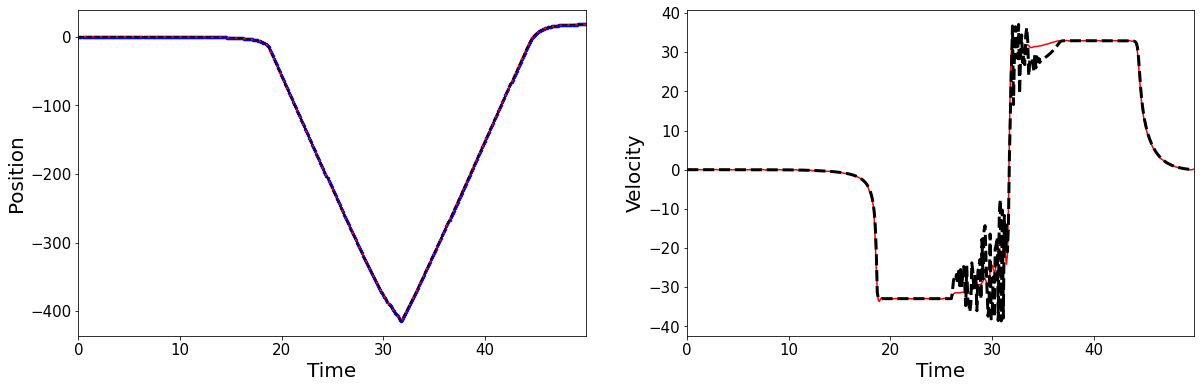

In [28]:
params, val = pynumdiff.optimize.kalman_smooth.constant_jerk(x, dt, params=None, 
                                                             tvgamma=tvgamma,
                                                             dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.kalman_smooth.constant_jerk(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)